In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())

from testsuite.utilities import Pareto_split
from testsuite.analysis import load_all #, plot_all_pareto_2d, PLOT_STYLE, plot_measure
from problem_setup import func, y, weighting, n_obj, n_dim

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from testsuite import optimisers
from pymoo.factory import get_performance_indicator
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
import inspect

In [3]:
names = ['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgo_ei', 'SmsEgo_$\\mu$', 'lhs']
true_names = ['MPoI', 'ParEGO', 'SAF: ei', 'SAF: $\mu$', 'SMS-EGO: ei', 'SMS-EGO: $\mu$', 'LHS']
D_names = {a:b for a, b in zip(names, true_names)}

In [4]:
OPTIMISER_NAMES = [cls[0].lower() for cls in inspect.getmembers(optimisers, inspect.isclass)
        if cls[1].__module__ == 'testsuite.optimisers']

In [5]:
def load_result(directory):
    result = load_all(directory, trailing_text = "_results.pkl")
    name = get_name_from_dir(directory)
    result['name'] = name
    return result

def get_name_from_dir(dir_string):
    bits = dir_string.split('_')
    name = [bit for bit in bits if bit.lower() in OPTIMISER_NAMES]

    if type(name) is list:
        name = name[0]
    if 'ei' in bits:
        name+='_ei'
    elif 'mean' in bits:
        name+='_$\mu$'
    return name

In [6]:
problem_path = './'

In [7]:
# load all results from directory tree
result_dirs = sorted(os.listdir(os.path.join(problem_path, "log_data/")))
results= []
for path in result_dirs:
    print(os.path.join(problem_path, 'log_data/',  path))
    result = load_result(os.path.join(problem_path, 'log_data/',  path))
    results.append(result)

./log_data/WFG2_Mpoi_init10_MultiSurrogate_Mpoi
./log_data/WFG2_ParEgo_init10
./log_data/WFG2_Saf_init10_MultiSurrogate_ei
./log_data/WFG2_Saf_init10_MultiSurrogate_mean
./log_data/WFG2_SmsEgoMu_init10_MultiSurrogate
./log_data/WFG2_SmsEgo_init10_MultiSurrogate
./log_data/WFG2_lhs_init10


In [8]:
for result in results:
    try:
        print(result['x'][0].shape)
    except:
        print(result['x'][0][0].shape)

(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(250, 5)
(10, 5)


In [9]:
p = np.load('../igd_refpoints/problem_refpoints/data/wfg2_4d_refpoints')[::10]

 /home/finley/miniconda3/envs/testsuite/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:838: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
 /home/finley/miniconda3/envs/testsuite/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:840: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


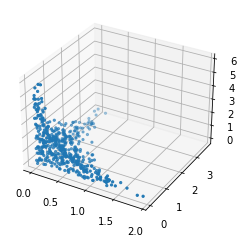

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(*p.T, s=5)

In [11]:
y_maxs = np.concatenate([r['y'] for r in results if r['name'] != "lhs"], axis=0).reshape(-1, n_obj)
ref_point =  y_maxs.max(axis=0)

In [12]:
# setup measurement systems
hv_measure = get_performance_indicator("hv", ref_point=ref_point)
igdp_measure = get_performance_indicator("igd+", p)

In [13]:
D = {}
for result in tqdm(results):
    print(result['name'])
    y = np.array(result['y'])

    if result['name'] == 'lhs':
        hvs = np.zeros((y.shape[0], y.shape[1]+10))
        igdps = np.zeros((y.shape[0], y.shape[1]+10))
        for i, yi in tqdm(enumerate(y)):
            for j, yii in enumerate(yi):
                hvs[i, j+10] = hv_measure.calc(yii)
                igdps[i, j+10] = igdp_measure.calc(yii)
    else:
        hvs = np.zeros((y.shape[0], y.shape[1]))
        igdps = np.zeros((y.shape[0], y.shape[1]))
        for i, yi in tqdm(enumerate(y)):
            for j in range(1, y.shape[1]+1):
                hvs[i, j-1] = hv_measure.calc(yi[:j])
                igdps[i, j-1] = igdp_measure.calc(yi[:j])

    D[result['name']] = {'name':result['name'], 'hypervolume': hvs, 'igd+':igdps, 'y': result['y'], 'hv_ref': ref_point, 'igd_ref': p, 'x': result['x'], 'seed': result['seed']}


  0%|          | 0/7 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Mpoi

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False




1it [00:07,  7.14s/it]
2it [00:18,  8.27s/it]
3it [00:26,  8.33s/it]
4it [00:33,  8.07s/it]
5it [00:43,  8.54s/it]
6it [00:50,  8.01s/it]
7it [01:00,  8.59s/it]
8it [01:13,  9.97s/it]
9it [01:25, 10.66s/it]
10it [01:34, 10.04s/it]
11it [01:41,  9.02s/it]
12it [01:47,  8.15s/it]
13it [01:53,  7.71s/it]
14it [02:01,  7.67s/it]
15it [02:08,  7.45s/it]
16it [02:15,  7.43s/it]
17it [02:22,  7.21s/it]
18it [02:30,  7.43s/it]
19it [02:38,  7.69s/it]
20it [02:45,  7.32s/it]
21it [03:00,  9.71s/it]
22it [03:12, 10.40s/it]
23it [03:20,  9.74s/it]
24it [03:32, 10.36s/it]
25it [03:38,  9.10s/it]
26it [03:45,  8.41s/it]
27it [03:57,  9.61s/it]
28it [04:05,  8.98s/it]
29it [04:15,  9.48s/it]
30it [04:23,  8.80s/it]
 14%|█▍        | 1/7 [04:23<26:23, 263.87s/it]
0it [00:00, ?it/s]

ParEgo



1it [00:05,  5.93s/it]
2it [00:11,  5.88s/it]
3it [00:17,  5.86s/it]
4it [00:23,  5.83s/it]
5it [00:28,  5.79s/it]
6it [00:35,  5.94s/it]
7it [00:40,  5.81s/it]
8it [00:46,  5.85s/it]
9it [00:53,  6.00s/it]
10it [00:58,  5.96s/it]
11it [01:04,  5.88s/it]
12it [01:10,  5.92s/it]
13it [01:16,  5.90s/it]
14it [01:22,  5.87s/it]
15it [01:27,  5.72s/it]
16it [01:33,  5.83s/it]
17it [01:39,  5.79s/it]
18it [01:45,  5.72s/it]
19it [01:50,  5.70s/it]
20it [01:58,  6.21s/it]
21it [02:03,  6.01s/it]
22it [02:09,  5.92s/it]
23it [02:15,  5.88s/it]
24it [02:20,  5.76s/it]
25it [02:26,  5.68s/it]
26it [02:31,  5.61s/it]
27it [02:37,  5.80s/it]
28it [02:43,  5.93s/it]
29it [02:49,  5.84s/it]
30it [02:55,  5.85s/it]
31it [03:01,  5.84s/it]
 29%|██▊       | 2/7 [07:24<19:55, 239.01s/it]
0it [00:00, ?it/s]

Saf_ei



1it [00:05,  5.97s/it]
2it [00:12,  5.99s/it]
3it [00:18,  6.01s/it]
4it [00:24,  6.07s/it]
5it [00:30,  6.15s/it]
6it [00:36,  6.14s/it]
7it [00:43,  6.23s/it]
8it [00:49,  6.41s/it]
9it [00:57,  6.72s/it]
10it [01:03,  6.66s/it]
11it [01:10,  6.59s/it]
12it [01:16,  6.49s/it]
13it [01:22,  6.35s/it]
14it [01:28,  6.24s/it]
15it [01:34,  6.26s/it]
16it [01:41,  6.20s/it]
17it [01:47,  6.16s/it]
18it [01:53,  6.15s/it]
19it [01:59,  6.12s/it]
20it [02:05,  6.12s/it]
21it [02:11,  6.23s/it]
22it [02:18,  6.31s/it]
23it [02:24,  6.20s/it]
24it [02:30,  6.26s/it]
25it [02:37,  6.30s/it]
26it [02:43,  6.33s/it]
27it [02:49,  6.30s/it]
28it [02:55,  6.26s/it]
29it [03:02,  6.27s/it]
30it [03:08,  6.28s/it]
31it [03:14,  6.28s/it]
 43%|████▎     | 3/7 [10:39<15:02, 225.68s/it]
0it [00:00, ?it/s]

Saf_$\mu$



1it [00:06,  6.08s/it]
2it [00:12,  6.25s/it]
3it [00:19,  6.29s/it]
4it [00:25,  6.20s/it]
5it [00:31,  6.18s/it]
6it [00:37,  6.25s/it]
7it [00:43,  6.25s/it]
8it [00:50,  6.22s/it]
9it [00:56,  6.30s/it]
10it [01:02,  6.33s/it]
11it [01:09,  6.26s/it]
12it [01:15,  6.33s/it]
13it [01:21,  6.32s/it]
14it [01:28,  6.36s/it]
15it [01:34,  6.27s/it]
16it [01:40,  6.22s/it]
17it [01:46,  6.22s/it]
18it [01:53,  6.34s/it]
19it [01:59,  6.22s/it]
20it [02:06,  6.42s/it]
21it [02:12,  6.39s/it]
22it [02:18,  6.36s/it]
23it [02:24,  6.33s/it]
24it [02:31,  6.46s/it]
25it [02:38,  6.52s/it]
26it [02:45,  6.54s/it]
27it [02:51,  6.49s/it]
28it [02:57,  6.46s/it]
29it [03:04,  6.42s/it]
30it [03:10,  6.45s/it]
31it [03:17,  6.37s/it]
 57%|█████▋    | 4/7 [13:56<10:51, 217.21s/it]
0it [00:00, ?it/s]

SmsEgoMu



1it [00:05,  5.99s/it]
2it [00:11,  5.87s/it]
3it [00:17,  5.81s/it]
4it [00:22,  5.77s/it]
5it [00:28,  5.70s/it]
6it [00:33,  5.64s/it]
7it [00:39,  5.50s/it]
8it [00:44,  5.50s/it]
9it [00:50,  5.55s/it]
10it [00:55,  5.52s/it]
11it [01:01,  5.61s/it]
12it [01:07,  5.58s/it]
13it [01:12,  5.51s/it]
14it [01:17,  5.51s/it]
15it [01:23,  5.54s/it]
16it [01:29,  5.55s/it]
17it [01:34,  5.50s/it]
18it [01:39,  5.46s/it]
19it [01:45,  5.52s/it]
20it [01:50,  5.49s/it]
21it [01:56,  5.56s/it]
22it [02:02,  5.51s/it]
23it [02:07,  5.57s/it]
24it [02:13,  5.51s/it]
25it [02:18,  5.47s/it]
26it [02:24,  5.49s/it]
27it [02:29,  5.58s/it]
28it [02:35,  5.61s/it]
29it [02:40,  5.55s/it]
30it [02:47,  5.75s/it]
31it [02:52,  5.57s/it]
 71%|███████▏  | 5/7 [16:49<06:47, 203.88s/it]
0it [00:00, ?it/s]

SmsEgo



1it [00:05,  5.55s/it]
2it [00:10,  5.50s/it]
3it [00:16,  5.52s/it]
4it [00:22,  5.51s/it]
5it [00:27,  5.48s/it]
6it [00:33,  5.55s/it]
7it [00:38,  5.53s/it]
8it [00:44,  5.55s/it]
9it [00:49,  5.48s/it]
10it [00:55,  5.51s/it]
11it [01:01,  5.65s/it]
12it [01:06,  5.60s/it]
13it [01:12,  5.63s/it]
14it [01:17,  5.64s/it]
15it [01:23,  5.59s/it]
16it [01:29,  5.61s/it]
17it [01:34,  5.56s/it]
18it [01:40,  5.55s/it]
19it [01:45,  5.54s/it]
20it [01:51,  5.58s/it]
21it [01:56,  5.61s/it]
22it [02:02,  5.56s/it]
23it [02:08,  5.75s/it]
24it [02:14,  5.74s/it]
25it [02:19,  5.65s/it]
26it [02:25,  5.65s/it]
27it [02:30,  5.63s/it]
28it [02:36,  5.55s/it]
29it [02:41,  5.47s/it]
30it [02:47,  5.49s/it]
31it [02:52,  5.58s/it]
 86%|████████▌ | 6/7 [19:42<03:14, 194.58s/it]
0it [00:00, ?it/s]

lhs



1it [00:05,  5.37s/it]
2it [00:10,  5.36s/it]
3it [00:16,  5.35s/it]
4it [00:21,  5.34s/it]
5it [00:26,  5.35s/it]
6it [00:32,  5.35s/it]
7it [00:37,  5.36s/it]
8it [00:42,  5.35s/it]
9it [00:48,  5.35s/it]
10it [00:53,  5.34s/it]
11it [00:58,  5.33s/it]
12it [01:04,  5.38s/it]
13it [01:09,  5.38s/it]
14it [01:14,  5.36s/it]
15it [01:20,  5.35s/it]
16it [01:25,  5.35s/it]
17it [01:31,  5.49s/it]
18it [01:37,  5.53s/it]
19it [01:43,  5.72s/it]
20it [01:50,  6.05s/it]
21it [01:57,  6.41s/it]
22it [02:08,  7.82s/it]
23it [02:25, 10.75s/it]
24it [02:40, 11.90s/it]
25it [02:45,  9.95s/it]
26it [02:51,  8.65s/it]
27it [02:56,  7.65s/it]
28it [03:02,  6.97s/it]
29it [03:07,  6.47s/it]
30it [03:13,  6.26s/it]
31it [03:20,  6.47s/it]
100%|██████████| 7/7 [23:03<00:00, 197.57s/it]


Mpoi
(30, 250)
ParEgo
(31, 250)
Saf_ei
(31, 250)
Saf_$\mu$
(31, 250)
SmsEgoMu
(31, 250)
SmsEgo
(31, 250)
lhs
(31, 251)


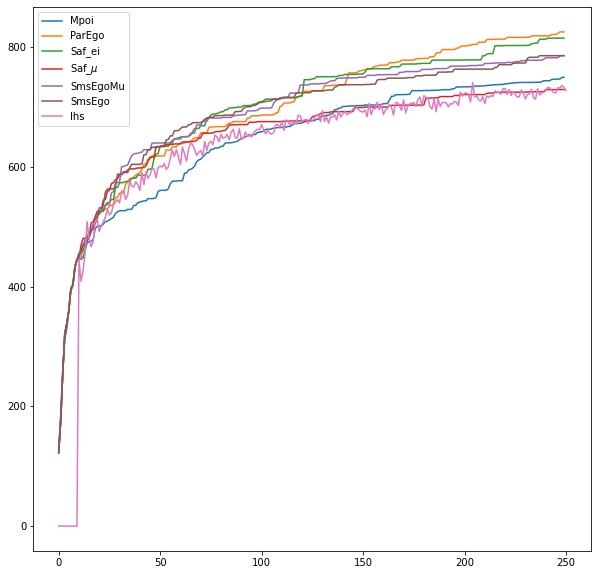

In [14]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca()
for name, d in D.items():
    print(name)
    print(np.shape(d['hypervolume']))
    ax.plot(np.median(d['hypervolume'], axis=0), label=name)
    
    
ax.legend()

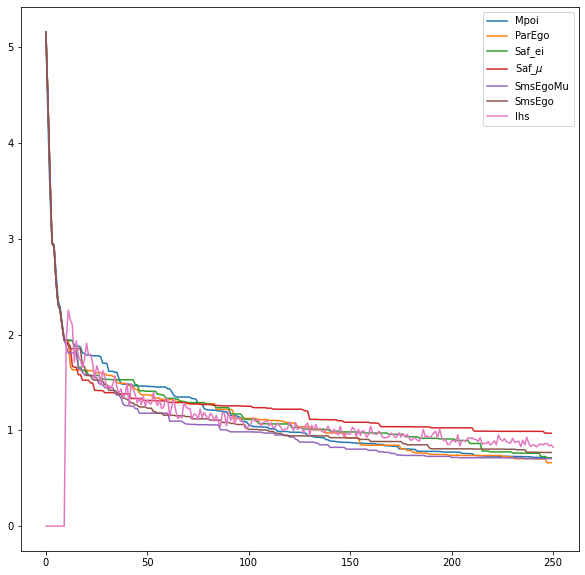

In [15]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca()
for name, d in D.items():
    ax.plot(np.median(d['igd+'], axis=0), label=name)
    
ax.legend()

In [41]:
%matplotlib qt

Mpoi
ParEgo
Saf_ei
Saf_$\mu$
Saf_$\mu$
SmsEgoMu
SmsEgo
SmsEgo
lhs


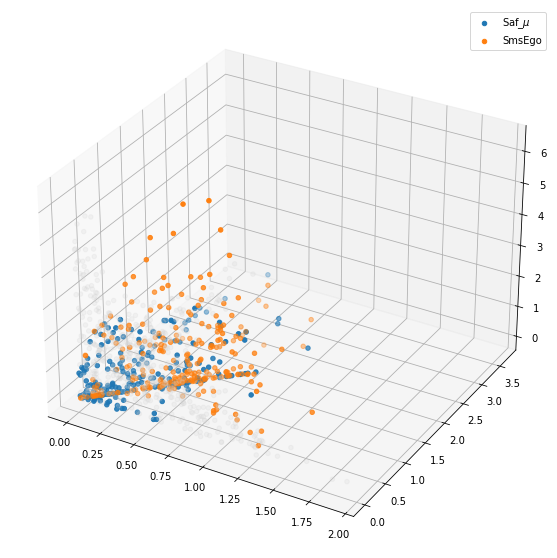

In [19]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
for name, d in D.items():
    print(name)
    if name in ['SmsEgo', 'Saf_$\mu$']:
        print(name)
#     for y in d['y']:
        y = d['y'][0]
        ax.scatter(*y.T, label=name)
ax.scatter(*p.T, color="lightgrey", alpha=0.2)
ax.legend()

In [21]:
D.keys()

dict_keys(['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgoMu', 'SmsEgo', 'lhs'])

In [31]:
import pickle as pkl
with open(os.path.join(problem_path, 'pkl_data/results__newsms_fixed.pkl'), 'wb') as outfile:
    pkl.dump(D, outfile)